# Setup

In [245]:
import torch
from conex import *
from pymonntorch import *

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image

from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader

from conex.helpers.filters import DoGFilter

In [246]:
def show_image(image,normal=False):
    plt.axis("off")
    if(normal):
        plt.imshow(image,cmap='gray',vmin=0,vmax=255)
    else:
        plt.imshow(image,cmap='gray')
    plt.show()

In [247]:
def confidence_crop_interspace(inp_width, inp_height, window_width, window_height):
    x1 = window_width//2
    x2 = (inp_width - 1) - (window_width//2)
    y1 = window_height//2 
    y2 = (inp_height - 1) - (window_height//2)

    center_x = random.randint(x1, x2)
    center_y = random.randint(y1, y2)
    center_coordinates = [center_x, center_y]
    top_left_x = center_x - (window_width//2)
    top_left_y = center_y - (window_height//2)
    top_left_coordinates = [top_left_x, top_left_y]
    coordinates = [center_coordinates, top_left_coordinates]

    return coordinates


# Dataset

In [248]:
from torchvision.datasets import MNIST
MNIST_ROOT = "./MNIST"

### Config

In [249]:
Input_Width = 24
Input_Height = 24
Crop_Window_Width = 10
Crop_Window_Height = 10

In [250]:
time_window = 100
crop_iteration = 2

dataset_directory_path = "./first_step"

transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels = 1), # not necessary
    Conv2dFilter(DoGFilter(size = 5, sigma_1 = 4, sigma_2 = 1, zero_mean=True, one_sum=True).unsqueeze(0).unsqueeze(0)),
    SqueezeTransform(dim = 0),
    SimplePoisson(time_window = time_window , ratio = 2),
])


dataset = MNIST(root=MNIST_ROOT, train=True, download=False, transform=transformation)
first_class = dataset.data[dataset.targets == 4]
second_class = dataset.data[dataset.targets == 9]
two_class_dataset = torch.cat((first_class, second_class), dim=0)
dataset_size = first_class.shape[0] + second_class.shape[0]


new_dataset = torch.empty(0,Crop_Window_Width, Crop_Window_Height)
centers = []


for i in range(0, dataset_size):
    for j in range (0, crop_iteration):
        img = two_class_dataset[i]  # 4 in range [0, 5842) ; 9 in range [5842, 11791)
        img = Image.fromarray(img.numpy(), mode="L")
        a = confidence_crop_interspace(Input_Width, Input_Height, Crop_Window_Width, Crop_Window_Height)
        centers.append((a[0][0], a[0][1]))
        cropped_image = torchvision.transforms.functional.crop(torch.sum(transformation(img), 0), a[1][1], a[1][0], Crop_Window_Width, Crop_Window_Height)
        cropped_image = cropped_image.view(1, Crop_Window_Width, Crop_Window_Height)
        new_dataset = torch.cat((new_dataset.data, cropped_image.data), dim=0)

dl = DataLoader(new_dataset,shuffle=True)


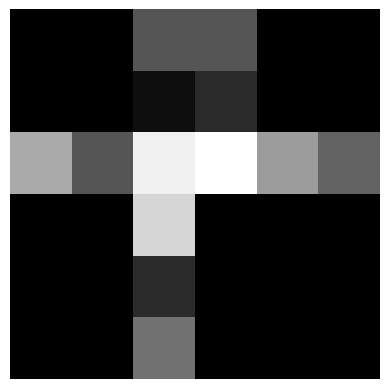

In [258]:
img = new_dataset[2] # 4 in range [0, 5842) ; 9 in range [5842, 11791)
img = Image.fromarray(img.numpy(), mode="L")
show_image(torch.sum(transformation(img), 0))